In [2]:
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import layers

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# plots
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [3]:
with open("../data/processed/processed_sub_dataset.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())

# load data for 10 subclasses
X_train = data['X_train_sub'] 
y_train = data['y_train_sub']
X_val = data['X_val_sub']
y_val = data['y_val_sub']
X_test = data['X_test_sub']
y_test = data['y_test_sub']

breed = data['classes_sub']
breed_id_map = {breed[i]:i for i in range(len(breed))}

y_train = np.array([breed_id_map[x] for x in y_train])
y_val = np.array([breed_id_map[x] for x in y_val])
y_test = np.array([breed_id_map[x] for x in y_test])

# with open("../data/processed/processed_full_dataset.pkl", "rb") as f:
#     data = pickle.load(f)
print(breed_id_map)

dict_keys(['X_train_sub', 'y_train_sub', 'X_val_sub', 'y_val_sub', 'X_test_sub', 'y_test_sub', 'classes_sub'])
{np.str_('flat'): 0, np.str_('german_short'): 1, np.str_('american_staffordshire_terrier'): 2, np.str_('ibizan_hound'): 3, np.str_('cairn'): 4, np.str_('kerry_blue_terrier'): 5, np.str_('maltese_dog'): 6, np.str_('bedlington_terrier'): 7, np.str_('english_setter'): 8, np.str_('sussex_spaniel'): 9}


In [4]:
# Check size
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"First 5 breeds in train: {y_train[:5]}")

X_train shape: (1000, 64, 64, 3)
X_val shape: (388, 64, 64, 3)
X_test shape: (390, 64, 64, 3)
First 5 breeds in train: [3 8 1 7 4]


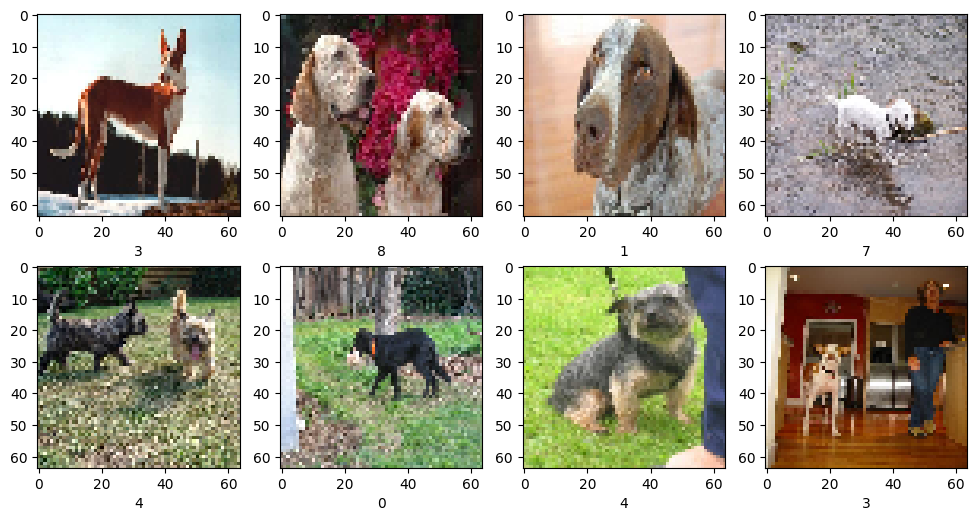

In [5]:
cols = 4
plt.figure(figsize=(cols * 3, 6)) 
for i in range(8):
    plt.subplot(2, cols, i + 1)
    plt.grid(False)
    img = array_to_img(X_train[i])
    plt.imshow(img)
    plt.xlabel(y_train[i])
plt.show()

Transformation and augmentation
- flip left and right - Dog images are usually symmetric, so flipping is safe
- random room in - Adds robustness to zoom
- Color and Lighting - ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05)

In [ ]:
def preprocess_data_part(X_train, labels, delta=0.2):
    """ apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 64, 64, 3)
    labels (np.ndarray): Labels of shape (N,)   
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 64, 64, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    """
    tf.random.set_seed(42)
    np.random.seed(42)
    
    # image augmentation - 1. random flip
    X_train_flip = tf.image.flip_left_right(X_train) 
    
    # image augmentation - 2. random rotation
    rotation_layer = tf.keras.layers.RandomRotation(factor=10/360.0)
    X_train_rotate = rotation_layer(X_train, training=True)

    # image augmentation - 3. scale <------------- this seems reasonable as some of the images has a big white space
    # resize_layer = tf.keras.layers.Resizing()
    # X_train_resize = tf.image.resize(X_train, target_size)

    # image augmentation - 4. adjusting color
    X_train_color = tf.image.random_brightness(X_train, max_delta=delta)
    X_train_color = tf.image.random_contrast(X_train_color, lower=1 - delta, upper=1 + delta)
    X_train_color = tf.image.random_saturation(X_train_color, lower=1 - delta, upper=1 + delta)

    # # concatenate original X_train and augmented X_train_augm data
    # X_train = np.concatenate((X_train, X_train_flip, X_train_rotate, X_train_color), axis=0)
    X_train = np.concatenate((X_train, X_train_flip, X_train_color), axis=0)

    # concatenate y_train (note the label is preserved)
    y_train_augm1 = labels
    y_train_augm2 = labels
    y_train_augm3 = labels
    # y_train = tf.concat([labels, y_train_augm1, y_train_augm2, y_train_augm3], axis=0)
    y_train = tf.concat([labels, y_train_augm1, y_train_augm3], axis=0)

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle).numpy() # transform X back to numpy array instead of tensor
    y_train = tf.gather(y_train, shuffle).numpy() # transform y back to numpy array instead of tensor

    # if isinstance(y_train[0], bytes):
    #     y_train = np.array([s.decode('utf-8') for s in y_train])

    return X_train, y_train

X_train_aug, y_train_aug = preprocess_data_part(X_train, y_train)
print(X_train_aug.shape)
print(y_train_aug.shape)

I0000 00:00:1752982596.469490  276032 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6073 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5


(3000, 64, 64, 3)
(3000,)


In [ ]:
# Build a CNN architecture
def model_builder(hp):
    # initialize model
    tf.keras.backend.clear_session()
    random.seed(42)
    tf.random.set_seed(42)
    np.random.seed(42)
    
    model = tf.keras.Sequential()

    # add convolutional layer
    hp_filters = hp.Int('filters', min_value=8, max_value=64, step=8)
    hp_kernel_size = hp.Int('kernel_size', min_value=2, max_value=5, step=1)
    kernel_tuple = (hp_kernel_size, hp_kernel_size)
    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])

    model.add(tf.keras.layers.Conv2D(
        filters=hp_filters,
        kernel_size=kernel_tuple,
        activation=hp_activation,
        padding='same',
        input_shape=(64, 64, 3)
    ))

    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    model.add(tf.keras.layers.Dropout(rate=hp_dropout))


    model.add(tf.keras.layers.Flatten())

    num_classes = len(np.unique(y_train_aug))
    model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

    # build and compile model
    model.build(input_shape=(None, 64, 64, 3))
    hp_lr = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return model

In [18]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='cnn_tuning'
)

tuner.search_space_summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1, restore_best_weights=True)

tuner.search(
    X_train_aug, y_train_aug,  # make sure this is integer encoded
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Trial 20 Complete [00h 00m 13s]
val_accuracy: 0.3479381501674652

Best val_accuracy So Far: 2.707261800765991
Total elapsed time: 00h 36m 11s


In [ ]:
# get the hyperparamers from the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

for hp_name in best_hps.values.keys():
    print(f"{hp_name}: {best_hps.get(hp_name)}")

filters: 64
kernel_size: 4
activation: tanh
dropout: 0.4
learning_rate: 0.0001


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
train_acc = best_model.evaluate(X_train_aug, y_train_aug, verbose=0)[1]
val_acc = best_model.evaluate(X_val, y_val, verbose=0)[1]

print("Best model summary:")
print(best_model.summary())
print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

/home/lyn/miniconda3/envs/dev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/lyn/miniconda3/envs/dev/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1752982599.428218  276235 service.cc:152] XLA service 0x70d5980059b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752982599.428269  276235 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-07-19 23:36:39.439692: I tensorflo

Best model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │       655,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 658,506 (2.51 MB)

 Trainable params: 658,506 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

None
Train Accuracy: 0.6463, Validation Accuracy: 0.3711


Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0321 - val_accuracy: 0.2990 - val_loss: 3.3450
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0301 - val_accuracy: 0.3015 - val_loss: 3.3508
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0298 - val_accuracy: 0.2938 - val_loss: 3.4125
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0273 - val_accuracy: 0.2964 - val_loss: 3.4259
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0256 - val_accuracy: 0.2964 - val_loss: 3.4670
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0235 - val_accuracy: 0.2990 - val_loss: 3.5132
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0235 - val_accuracy: 0.2964 - val_loss: 3.5265
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0212 - val_accuracy: 0.2938 - val_loss

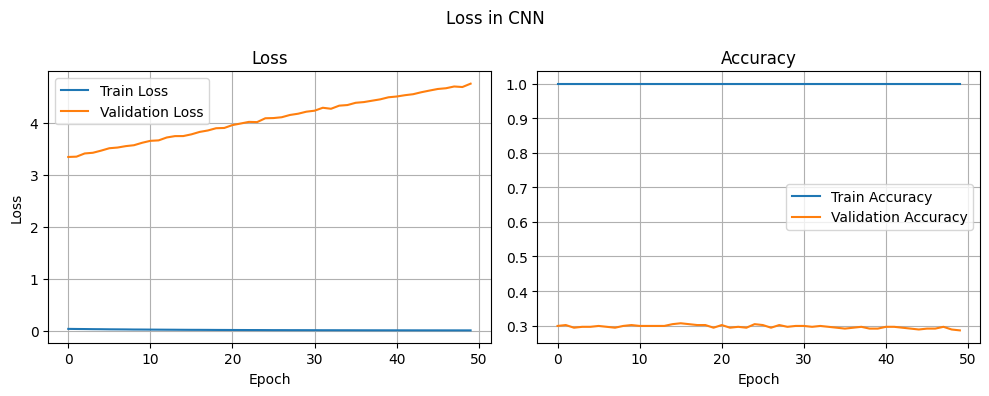

Train Accuracy: 1.0000, Validation Accuracy: 0.2861


In [ ]:
history = best_model.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    epochs=50,
    verbose=1)

# plot loss curves
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Plot Train Loss
axes[0].plot(history.history['loss'], label='Train Loss', color='tab:blue')
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='tab:orange')
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# Plot Validation Loss
axes[1].plot(history.history['accuracy'], label='Train Accuracy', color='tab:blue')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='tab:orange')
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].legend()
axes[1].grid(True)

plt.suptitle("Loss in CNN", fontsize=12)
plt.tight_layout()
plt.show()

# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
train_acc = history.history['accuracy'][-1]
val_acc =  history.history['val_accuracy'][-1]
print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")